Допустим есть какие-то признаки, по которым раскидано сколько-то объектов

Иерархическая кластеризация группы не показывает, а вот сами элементы в пары по подобию объединяет - получает эдакое дерево решений, но не кластеризирует.

С К-средними придется точно сказать, сколько мы ждем классов. К примеру, ставим 2, он случайно поставит 2 точки, и может из-за этого разные группы каждый следующий раз получить разные, после перемещения центроида точки, он потенциально сопоставит их максимально к середине группы объектов.

seg b1

Задача #1. Функция которая будет читать seg b1, на выходе - список(словарь(frm-сек начала, t-сек конца, метка-собственно метка))

В самом сеге там не миллисекунды, а номер байта, с которого оно начинается. Сверху есть BYTE_PER_SAMPLE, на него надо разделить.

Сначала читаем все в один массив, затем по строчкам разбираем и т.д.

In [ ]:
path = r"/content/cta0001.seg_B1"

In [ ]:
def read_seg(path):
  fl_2 = [x.strip() for x in open(path, encoding = 'UTF-8')]
  third_line = fl_2[2]
  byte_per_sample = 0
  for c in range(len(third_line)):
    if third_line[c] == '=':
      byte_per_sample = int(third_line[c + 1:])
  fl_labels = fl_2[7:]
  res = []
  for i in range(1, len(fl_labels) - 1):
    dick = {"frm": [], "t": [], "m": []}
    i = i + 1
    minus_line = fl_labels[i - 1].split(',')
    minus_line_new = []
    if minus_line[2] != "":
      minus_line_new = minus_line[:2] + [",".join(minus_line[2:])]
    else:
      minus_line_new = minus_line
    line = fl_labels[i].split(',')
    line_new = line[:2] 
    dick['frm'] = int(minus_line_new[0]) / byte_per_sample
    dick['t'] = int(line_new[0]) / byte_per_sample
    dick['m'] = minus_line_new[2]
    res += [dick]
  return res

In [ ]:
res = read_seg(path)

In [ ]:
print(res[:10])

[{'frm': 4246.0, 't': 6354.0, 'm': 'u0'}, {'frm': 6354.0, 't': 6854.0, 'm': "r'"}, {'frm': 6854.0, 't': 9090.0, 'm': 'i4'}, {'frm': 9090.0, 't': 12452.0, 'm': 't'}, {'frm': 12452.0, 't': 12970.0, 'm': "r'"}, {'frm': 12970.0, 't': 15772.0, 'm': 'i0'}, {'frm': 15772.0, 't': 18403.0, 'm': 'f'}, {'frm': 18403.0, 't': 19302.0, 'm': 'a4'}, {'frm': 19302.0, 't': 20809.0, 'm': 'n'}, {'frm': 20809.0, 't': 22254.0, 'm': 'a4'}]


Сделать список [длительность, степень ударности]. Создать vowels - список, куда добавим только гласные (массив словарей, начало, конец, метка, степень ударности, Гласная - элемент с 0, степень ударности эл-т с 1)

In [ ]:
def pearson(v1,v2):
  # Simple sums
  sum1=sum(v1)
  sum2=sum(v2)
  
  # Sums of the squares
  sum1Sq=sum([pow(v,2) for v in v1])
  sum2Sq=sum([pow(v,2) for v in v2])	
  
  # Sum of the products
  pSum=sum([v1[i]*v2[i] for i in range(len(v1))])
  
  # Calculate r (Pearson score)
  num=pSum-(sum1*sum2/len(v1))
  den=sqrt((sum1Sq-pow(sum1,2)/len(v1))*(sum2Sq-pow(sum2,2)/len(v1)))
  if den==0: return 0

  return 1.0-num/den


In [ ]:
import random


def kcluster(rows,distance=pearson,k=4):
  # Determine the minimum and maximum values for each point
  ranges=[(min([row[i] for row in rows]),max([row[i] for row in rows])) for i in range(len(rows[0]))]
  # Create k randomly placed centroids
  clusters=[[random.random()*(ranges[i][1]-ranges[i][0])+ranges[i][0] for i in range(len(rows[0]))] for j in range(k)]

  
  lastmatches=None

  for t in range(100):

    print('Iteration {t}')

    bestmatches=[[] for i in range(k)]

    # Find which centroid is the closest for each row
    for j in range(len(rows)):
      row=rows[j]
      bestmatch=0
      for i in range(k):
        d=distance(clusters[i],row)
        if d<distance(clusters[bestmatch],row): bestmatch=i
      bestmatches[bestmatch].append(j)
    # If the results are the same as last time, this is complete
    if bestmatches==lastmatches: break
    lastmatches=bestmatches

    # Move the centroids to the average of their members
    for i in range(k):
      avgs=[0.0]*len(rows[0])
      if len(bestmatches[i])>0:
        for rowid in bestmatches[i]:
          for m in range(len(rows[rowid])):
            avgs[m]+=rows[rowid][m]
        for j in range(len(avgs)):
          avgs[j]/=len(bestmatches[i])
        clusters[i]=avgs
  return bestmatches


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() # для стилизации графиков
import numpy as np


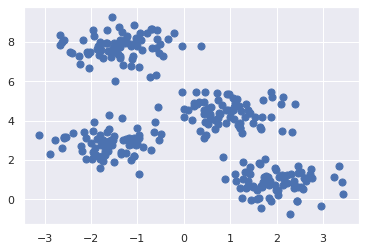

In [ ]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50)

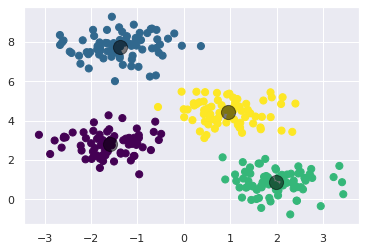

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

[[ 8.36856841e-01  2.13635938e+00]
 [-1.41365810e+00  7.40962324e+00]
 [ 1.15521298e+00  5.09961887e+00]
 [-1.01861632e+00  7.81491465e+00]
 [ 1.27135141e+00  1.89254207e+00]
 [ 3.43761754e+00  2.61654166e-01]
 [-1.80822253e+00  1.59701749e+00]
 [ 1.41372442e+00  4.38117707e+00]
 [-2.04932168e-01  8.43209665e+00]
 [-7.11099611e-01  8.66043846e+00]
 [-1.71237268e+00  2.77780226e+00]
 [-2.67000792e+00  8.35389140e+00]
 [ 1.24258802e+00  4.50399192e+00]
 [-2.22783649e+00  6.89479938e+00]
 [ 1.45513831e+00 -2.91989981e-02]
 [ 4.53791789e-01  3.95647753e+00]
 [ 1.06923853e+00  4.53068484e+00]
 [ 2.56936589e+00  5.07048304e-01]
 [-1.06690610e+00  3.13165795e+00]
 [-1.07859101e+00  2.20451529e+00]
 [ 2.71506328e+00  1.29082190e+00]
 [ 1.77710994e+00  1.18655254e+00]
 [ 7.34363910e-01  5.03725437e+00]
 [-1.99648151e+00  2.85164868e+00]
 [-1.91828017e+00  2.60516867e+00]
 [-5.55523811e-01  4.69595848e+00]
 [ 1.69747910e+00  8.66123282e-01]
 [ 5.94762432e-01  4.70964730e+00]
 [-2.88024255e+00  2

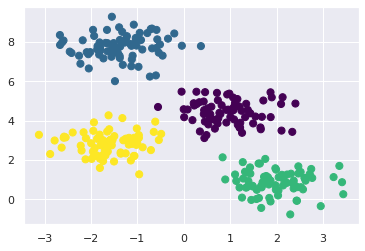

In [ ]:
from sklearn.metrics import pairwise_distances_argmin
def find_clusters(X, n_clusters, rseed=2):
   # 1. Выбираем кластеры случайным образом
    rng = np.random.RandomState(rseed)

    i = rng.permutation(X.shape[0])[:n_clusters]
    print(X)
    centers = X[i]
    while True:
      # 2a. Присваиваем метки в соответствии с ближайшим центром
      labels = pairwise_distances_argmin(X, centers)
      # 2b. Находим новые центры, исходя из средних значений точек
      new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])
      # 2c. Проверяем сходимость
      if np.all(centers == new_centers):
        break
      centers = new_centers
    return centers, labels
centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

In [ ]:
import os

dirname = r"."

for root, dirnames, files in os.walk(dirname):
  for file in files:
    fullname = os.path.join(root, file)
    print(fullname)

In [ ]:
import os

dirname = r"."

for file in os.listdir(dirname):
  fullname = os.path.join(root, file)
  print(fullname)